In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# %cd drive/MyDrive/Magistrale/ExplainableAI/dataset
# import os
# os.getcwd()

In [5]:
#!unzip dataset.zip

## Import, data read and processing

In [6]:
# Make all necessary imports
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import os
import gc
import cv2
import glob
import time
import torch
import numpy as np
import torchvision
from utils import *
import pandas as pd
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
from scipy.fft import fft2
from tabulate import tabulate
import matplotlib.pyplot as plt
from colorsys import hls_to_rgb
from ScatNet_rgb import ScatNet2D
from torchvision import transforms
from CNN_128x128 import CNN_128x128
from sklearn.metrics import f1_score
from kymatio.torch import Scattering2D
from torch.utils.data import DataLoader
from torchvision import transforms as v2
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from concurrent.futures import ThreadPoolExecutor

from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: ',device)

models_trained_path = 'best/'
if not os.path.exists(models_trained_path):                
    os.makedirs(models_trained_path)


Device:  cuda


In [7]:
def process_image(filename):
    img = Image.open(filename)
    img = img.resize((128, 128))
    return img

def process_csv_file(file_path):
    # Read CSV file
    data = pd.read_csv(file_path)

    # Process columns
    data['f1_val'] = data['f1_val'].apply(lambda x: [float(i) for i in x[1:-1].split(',')])
    data['f1_train'] = data['f1_train'].apply(lambda x: [float(i) for i in x[1:-1].split(',')])
    data['acc_val'] = data['acc_val'].apply(lambda x: [float(i) for i in x[1:-1].split(',')])
    data['acc_train'] = data['acc_train'].apply(lambda x: [float(i) for i in x[1:-1].split(',')])
    data['loss_val'] = data['loss_val'].apply(lambda x: [float(i) for i in x[1:-1].split(',')])
    data['loss_train'] = data['loss_train'].apply(lambda x: [float(i) for i in x[1:-1].split(',')])
    data['num_epoch'] = data['num_epoch'].apply(lambda x: int(x))

    # Calculate the number of epochs
    num_epochs = data['num_epoch'][0]

    return data, num_epochs

def colorize(z):
    n, m = z.shape
    c = np.zeros((n, m, 3))
    c[np.isinf(z)] = (1.0, 1.0, 1.0)
    c[np.isnan(z)] = (0.5, 0.5, 0.5)

    idx = ~(np.isinf(z) + np.isnan(z))
    A = (np.angle(z[idx]) + np.pi) / (2*np.pi)
    A = (A + 0.5) % 1.0
    B = 1.0/(1.0 + abs(z[idx])**0.3)
    c[idx] = [hls_to_rgb(a, b, 0.8) for a, b in zip(A, B)]
    return c



### Read data

  1%|▏         | 40/2769 [00:00<00:07, 378.82it/s]

100%|██████████| 2151/2151 [00:04<00:00, 481.09it/s]


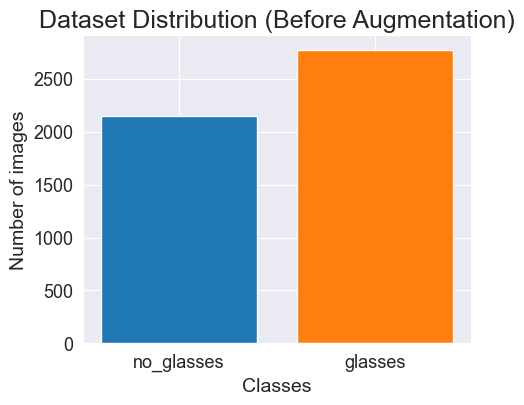

+------------+---------+
| Class      |   Count |
+============+=========+
| No Glasses |    2151 |
+------------+---------+
| Glasses    |    2769 |
+------------+---------+


In [8]:
labels, images = [], []

# Load images with glasses
open_path = 'archive_488/Images/Images/glasses/'
with ThreadPoolExecutor() as executor:
    filenames = glob.glob(open_path + '*.jpg')
    for img in tqdm(executor.map(process_image, filenames), total=len(filenames)):
        images.append(img)
        labels.append(1)

# Load images without glasses
open_path = 'archive_488/Images/Images/no_glasses/'
with ThreadPoolExecutor() as executor:
    filenames = glob.glob(open_path + '*.jpg')
    for img in tqdm(executor.map(process_image, filenames), total=len(filenames)):
        images.append(img)
        labels.append(0)


labels = np.array(labels)
labels = labels.astype('uint8')

# Plot dataset distribution (before augmentation)
fig, ax = plt.subplots(figsize=(5, 4))

class_labels = ['no_glasses', 'glasses']
class_counts = [np.count_nonzero(labels == 0), np.count_nonzero(labels == 1)]
colors = ['tab:blue', 'tab:orange']

ax.bar(class_labels, class_counts, color=colors)
ax.set_xlabel('Classes')
ax.set_ylabel('Number of images')
ax.set_title('Dataset Distribution (Before Augmentation)')
plt.show()

# Print table with dataset distribution
data = {
    'Class': ['No Glasses', 'Glasses'],
    'Count': [np.count_nonzero(labels == 0), np.count_nonzero(labels == 1)]
}
table = tabulate(data, headers='keys', tablefmt='grid')
print(table)

# Convert labels to uint8
labels = np.array(labels, dtype='uint8')

### Split data into train and test
split the data into train(80%) and test(20%) and perfmorm data augmentation on train data to increase the diversity of the data.

100%|██████████| 984/984 [00:00<00:00, 4211.54it/s]
C:\Users\enric\AppData\Local\Temp\ipykernel_1504\1018075047.py:34: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3618.)
  ax[i, j].imshow(X_train[num].T)


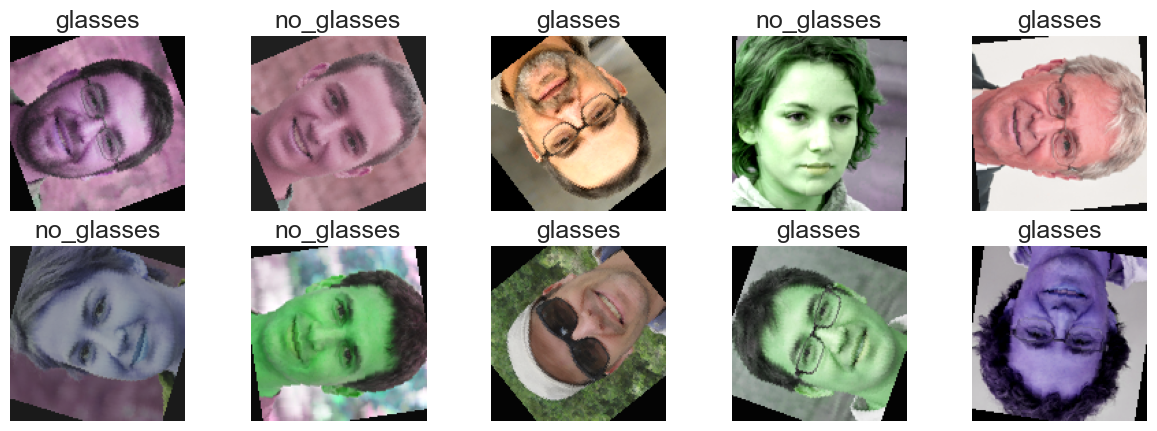

In [9]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=42)
del images, labels


test_aug = v2.Compose([
    v2.ToTensor(),
])

preprocess = v2.Compose([
    v2.ToTensor(),
    v2.Resize((128,128)),
])

train_aug = v2.Compose([
    v2.ToTensor(),
    v2.RandomRotation(degrees=180),
    v2.RandomHorizontalFlip(p=1),
    v2.RandomVerticalFlip(p=1),
    v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.4),
])

#Data augmentation for the training set
#X_train_resize = [test_aug(img) for img in X_train]  #Normal image not augmented
X_train = [train_aug(img) for img in tqdm(X_train)]
#y_train = np.concatenate((y_train, y_train), axis=0) #Duplicating the labels
X_test = [preprocess(img) for img in tqdm(X_test)]

#plot 10 random images
fig, ax = plt.subplots(2, 5, figsize=(15, 5))
for i in range(2):
    for j in range(5):
        num = np.random.randint(0, len(X_train))
        ax[i, j].imshow(X_train[num].T)
        label = 'no_glasses' if y_train[num]==0 else 'glasses'
        ax[i, j].set_title(label)
        ax[i, j].axis('off')
plt.show()



In [8]:
"""
RUN CELLE SOPRA
"""

'\nRUN CELLE SOPRA\n'

### CNN

In [9]:

# Clearing memory
gc.collect() 
torch.cuda.empty_cache() 

# Splitting data into 5 folds for training and validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#---------------------------------------
num_epochs =  50      # number of epochs              
lr = 0.01              # learning rate
#---------------------------------------                                       
            
best_acc, best_f1 = 0.0, 0.0  
acc_train_tot, f1_train_tot, acc_val_tot, f1_val_tot,losses_train_tot,losses_val_tot = [], [], [], [], [], []

# Training and validation loop
for fold, (train_index, val_index) in enumerate(kf.split(X_train)):

    train_dataset = CustomDataset(np.array(X_train)[train_index],y_train[train_index])   
    test_dataset = CustomDataset(np.array(X_train)[val_index],y_train[val_index])      
    
    train_loader = DataLoader(train_dataset, batch_size=16)
    val_loader = DataLoader(test_dataset, batch_size=350)

    model_kf = CNN_128x128(input_channel=3,num_classes=len(np.unique(y_train))).to(device)

    optimizer = torch.optim.SGD(model_kf.parameters(),lr = lr, momentum=0.5)
    #optimizer = torch.optim.Adam(model_kf.parameters(), lr=lr)             #Aadam optimizer

    criterion_kf = torch.nn.CrossEntropyLoss()  
    
    acc_train_fold, f1_train_fold, acc_val_fold, f1_val_fold, losses_train_fold, losses_val_fold = [], [], [], [], [], []
   

    # Epoch loop
    for epoch in (pbar := tqdm(range(num_epochs))):
        model_kf.train()
        pred_label_test = torch.empty((0)).to(device)    
        true_label_test = torch.empty((0)).to(device)
        pred_label_train = torch.empty((0)).to(device)    
        true_label_train = torch.empty((0)).to(device)

        # Training loop
        for data_tr in train_loader:
            optimizer.zero_grad()
            inputs, labels = data_tr
            batch,_,_,_ = inputs.shape
            inputs = inputs.view(batch,3,128,128).float().to(device)
            labels = labels.to(device)
            output_kf = model_kf(inputs)
            _, predict = output_kf.max(1)
            pred_label_train = torch.cat((pred_label_train,predict),dim=0)
            true_label_train = torch.cat((true_label_train,labels),dim=0)
            loss = criterion_kf(output_kf, labels)
            loss.backward()
            optimizer.step()
        losses_train_fold.append(loss.item())
        acc_train_ep = accuracy_score(true_label_train.cpu(),pred_label_train.cpu())
        acc_train_fold.append(acc_train_ep)
        f1_train_ep = f1_score(true_label_train.cpu(), pred_label_train.cpu(), average='binary')
        f1_train_fold.append(f1_train_ep)
        

        # Evaluation loop
        model_kf.eval()
        with torch.no_grad():
            for data_ts in val_loader:
                inputs, labels = data_ts
                b,_,_,_ = inputs.shape
                inputs = inputs.view(b,3,128,128).float().to(device)
                labels = labels.to(device)
                output_kf = model_kf(inputs)
                _, predicted = output_kf.max(1)
                loss_val = criterion_kf(output_kf, labels)
                pred_label_test = torch.cat((pred_label_test,predicted),dim=0)
                true_label_test = torch.cat((true_label_test,labels),dim=0)        
        losses_val_fold.append(loss_val.item())
        f1_val_ep = f1_score(true_label_test.cpu(), pred_label_test.cpu(), average='binary')
        f1_val_fold.append(f1_val_ep)
        acc_val_ep = accuracy_score(true_label_test.cpu(),pred_label_test.cpu())
        acc_val_fold.append(acc_val_ep)  
        pbar.set_description(f"Fold{fold+1}| loss_tr: {loss.item():.4f} - loss_ev: {loss_val.item():.4f}| acc_tr: {acc_train_ep*100:.2f}% - acc_ev: {acc_val_ep*100:.2f}%| f1_tr: {f1_train_ep:.4f} - f1_ev: {f1_val_ep:.4f}")

    acc_train_tot.append(acc_train_fold)        # Save accuracy for each fold
    f1_train_tot.append(f1_train_fold)          # Save f1 score for each fold

    acc_val_tot.append(acc_val_fold)            # Save accuracy for each fold
    f1_val_tot.append(f1_val_fold)              # Save f1 score for each fold

    losses_train_tot.append(losses_train_fold)  # Save loss for each fold
    losses_val_tot.append(losses_val_fold)      # Save loss for each fold

 
    # Save model
    torch.save(model_kf.state_dict(),"model/rgb/"+'CNN_model_'+"fold_"+str(fold+1)+'_trained_'+str(num_epochs)+'epoch'+"_validation_accuracy_"+str(acc_val_ep)+'.pt')
    if acc_val_ep > best_acc:         
        best_model_path = models_trained_path+'CNN_RGB_best_model_trained_'+str(num_epochs)+'epoch'+"_validation_accuracy_"+str(acc_val_ep)+'.pt'                                                   
        torch.save(model_kf.state_dict(), best_model_path)
        best_acc = acc_val_ep
        print(f"Best model saved with accuracy: {best_acc:.4f}")

    # Clearing memory
    del model_kf
    del optimizer
    del criterion_kf


print(f"Mean f1 score: {np.mean(np.array(f1_val_tot)[:,num_epochs-1]):.4f}")
print(f"Mean accuracy: {np.mean(np.array(acc_val_tot)[:,num_epochs-1])* 100:.2f}%")
print(f"Mean loss: {np.mean(np.array(losses_val_tot)[:,num_epochs-1]):.4f}")
print(f"Standard deviation: {np.std(np.array(acc_val_tot)[:,num_epochs-1]):.4f}")
now = time.strftime("%Y-%m-%d_%H-%M-%S")

# Save training results to csv
data = pd.DataFrame(columns=['f1_train','f1_val','acc_train','acc_val','loss_train','loss_val','num_epoch'])
data['f1_train'] = f1_train_tot
data['f1_val'] = f1_val_tot
data['acc_train'] = acc_train_tot
data['acc_val'] = acc_val_tot
data['loss_train'] = losses_train_tot
data['loss_val'] = losses_val_tot
data['num_epoch'] = num_epochs
data.to_csv('model/'+'CNN_RGB_model_training_'+str(num_epochs)+'epoch_'+now+'.csv', index=False)

Fold1| loss_tr: 0.3133 - loss_ev: 0.3235| acc_tr: 99.08% - acc_ev: 97.72%| f1_tr: 0.9917 - f1_ev: 0.9795: 100%|██████████| 50/50 [01:26<00:00,  1.73s/it]


Best model saved with accuracy: 0.9772


Fold2| loss_tr: 0.3133 - loss_ev: 0.3588| acc_tr: 99.46% - acc_ev: 98.73%| f1_tr: 0.9952 - f1_ev: 0.9885: 100%|██████████| 50/50 [01:25<00:00,  1.70s/it]


Best model saved with accuracy: 0.9873


Fold3| loss_tr: 0.3134 - loss_ev: 0.3148| acc_tr: 98.54% - acc_ev: 96.82%| f1_tr: 0.9869 - f1_ev: 0.9715: 100%|██████████| 50/50 [01:25<00:00,  1.71s/it]
Fold4| loss_tr: 0.3133 - loss_ev: 0.3452| acc_tr: 99.17% - acc_ev: 96.95%| f1_tr: 0.9926 - f1_ev: 0.9720: 100%|██████████| 50/50 [01:24<00:00,  1.69s/it]
Fold5| loss_tr: 0.3134 - loss_ev: 0.3218| acc_tr: 99.21% - acc_ev: 97.20%| f1_tr: 0.9928 - f1_ev: 0.9752: 100%|██████████| 50/50 [01:20<00:00,  1.61s/it]

Mean f1 score: 0.9773
Mean accuracy: 97.48%
Mean loss: 0.3328
Standard deviation: 0.0069


+--------+------------+--------------+------------------+--------------------+--------------+----------------+
| Fold   |   F1 (Val) |   F1 (Train) |   Accuracy (Val) |   Accuracy (Train) |   Loss (Val) |   Loss (Train) |
+========+============+==============+==================+====================+==============+================+
| fold 1 |   0.92625  |     0.932328 |         0.909188 |           0.915203 |     0.387399 |       0.390361 |
+--------+------------+--------------+------------------+--------------------+--------------+----------------+
| fold 2 |   0.938097 |     0.930022 |         0.921449 |           0.912906 |     0.392215 |       0.367555 |
+--------+------------+--------------+------------------+--------------------+--------------+----------------+
| fold 3 |   0.921491 |     0.92541  |         0.901728 |           0.907666 |     0.404772 |       0.385298 |
+--------+------------+--------------+------------------+--------------------+--------------+----------------+
|

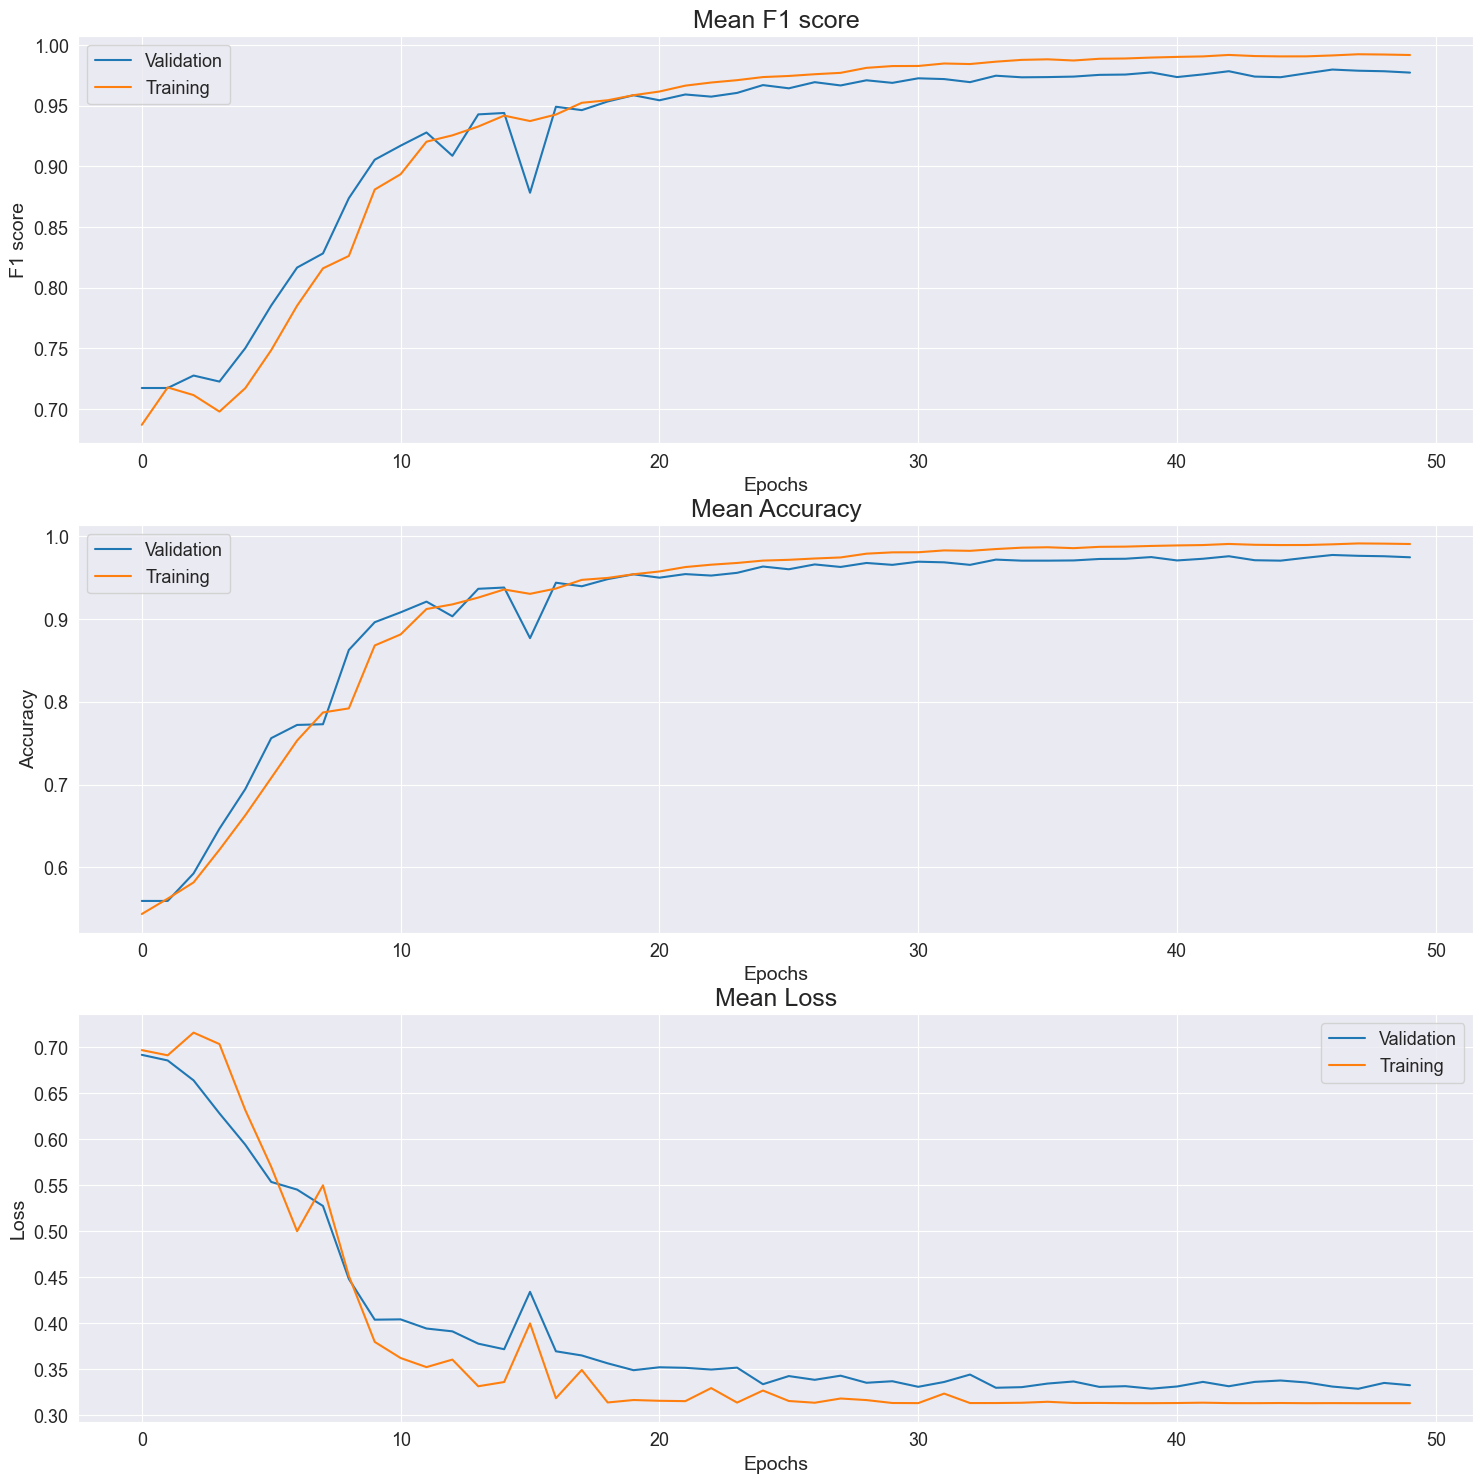

In [14]:
now = time.strftime("%Y-%m-%d_%H-%M-%S")

name = 'CNN_RGB_model_training_50epoch_2024-03-02_12-30-47'
data, num_epochs = process_csv_file('model/'+name+'.csv')

# Print in a table the mean values of the metrics for each fold
mean_lists = {
    'Fold': ["fold 1","fold 2","fold 3","fold 4","fold 5"],
    'F1 (Val)': [np.mean(data['f1_val'][i]) for i in range(len(data['f1_val']))],
    'F1 (Train)': [np.mean(data['f1_train'][i]) for i in range(len(data['f1_train']))],
    'Accuracy (Val)': [np.mean(data['acc_val'][i]) for i in range(len(data['acc_val']))],
    'Accuracy (Train)': [np.mean(data['acc_train'][i]) for i in range(len(data['acc_train']))],
    'Loss (Val)': [np.mean(data['loss_val'][i]) for i in range(len(data['loss_val']))],
    'Loss (Train)': [np.mean(data['loss_train'][i]) for i in range(len(data['loss_train']))]
}
table = tabulate(mean_lists, headers='keys', tablefmt='grid')
print(table)

# Plot training results from data
fig, ax = plt.subplots(3, 1, figsize=(18, 18))
ax[0].plot([float(sum(col))/len(col) for col in zip(*data['f1_val'])], label='Validation')
ax[0].plot([float(sum(col))/len(col) for col in zip(*data['f1_train'])], label='Training')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('F1 score')
ax[0].set_title('Mean F1 score')
ax[0].legend()

ax[1].plot([float(sum(col))/len(col) for col in zip(*data['acc_val'])], label='Validation')
ax[1].plot([float(sum(col))/len(col) for col in zip(*data['acc_train'])], label='Training')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Mean Accuracy')
ax[1].legend()

ax[2].plot([float(sum(col))/len(col) for col in zip(*data['loss_val'])], label='Validation')
ax[2].plot([float(sum(col))/len(col) for col in zip(*data['loss_train'])], label='Training')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].set_title('Mean Loss')
ax[2].legend()

plt.show()



### Plot and save

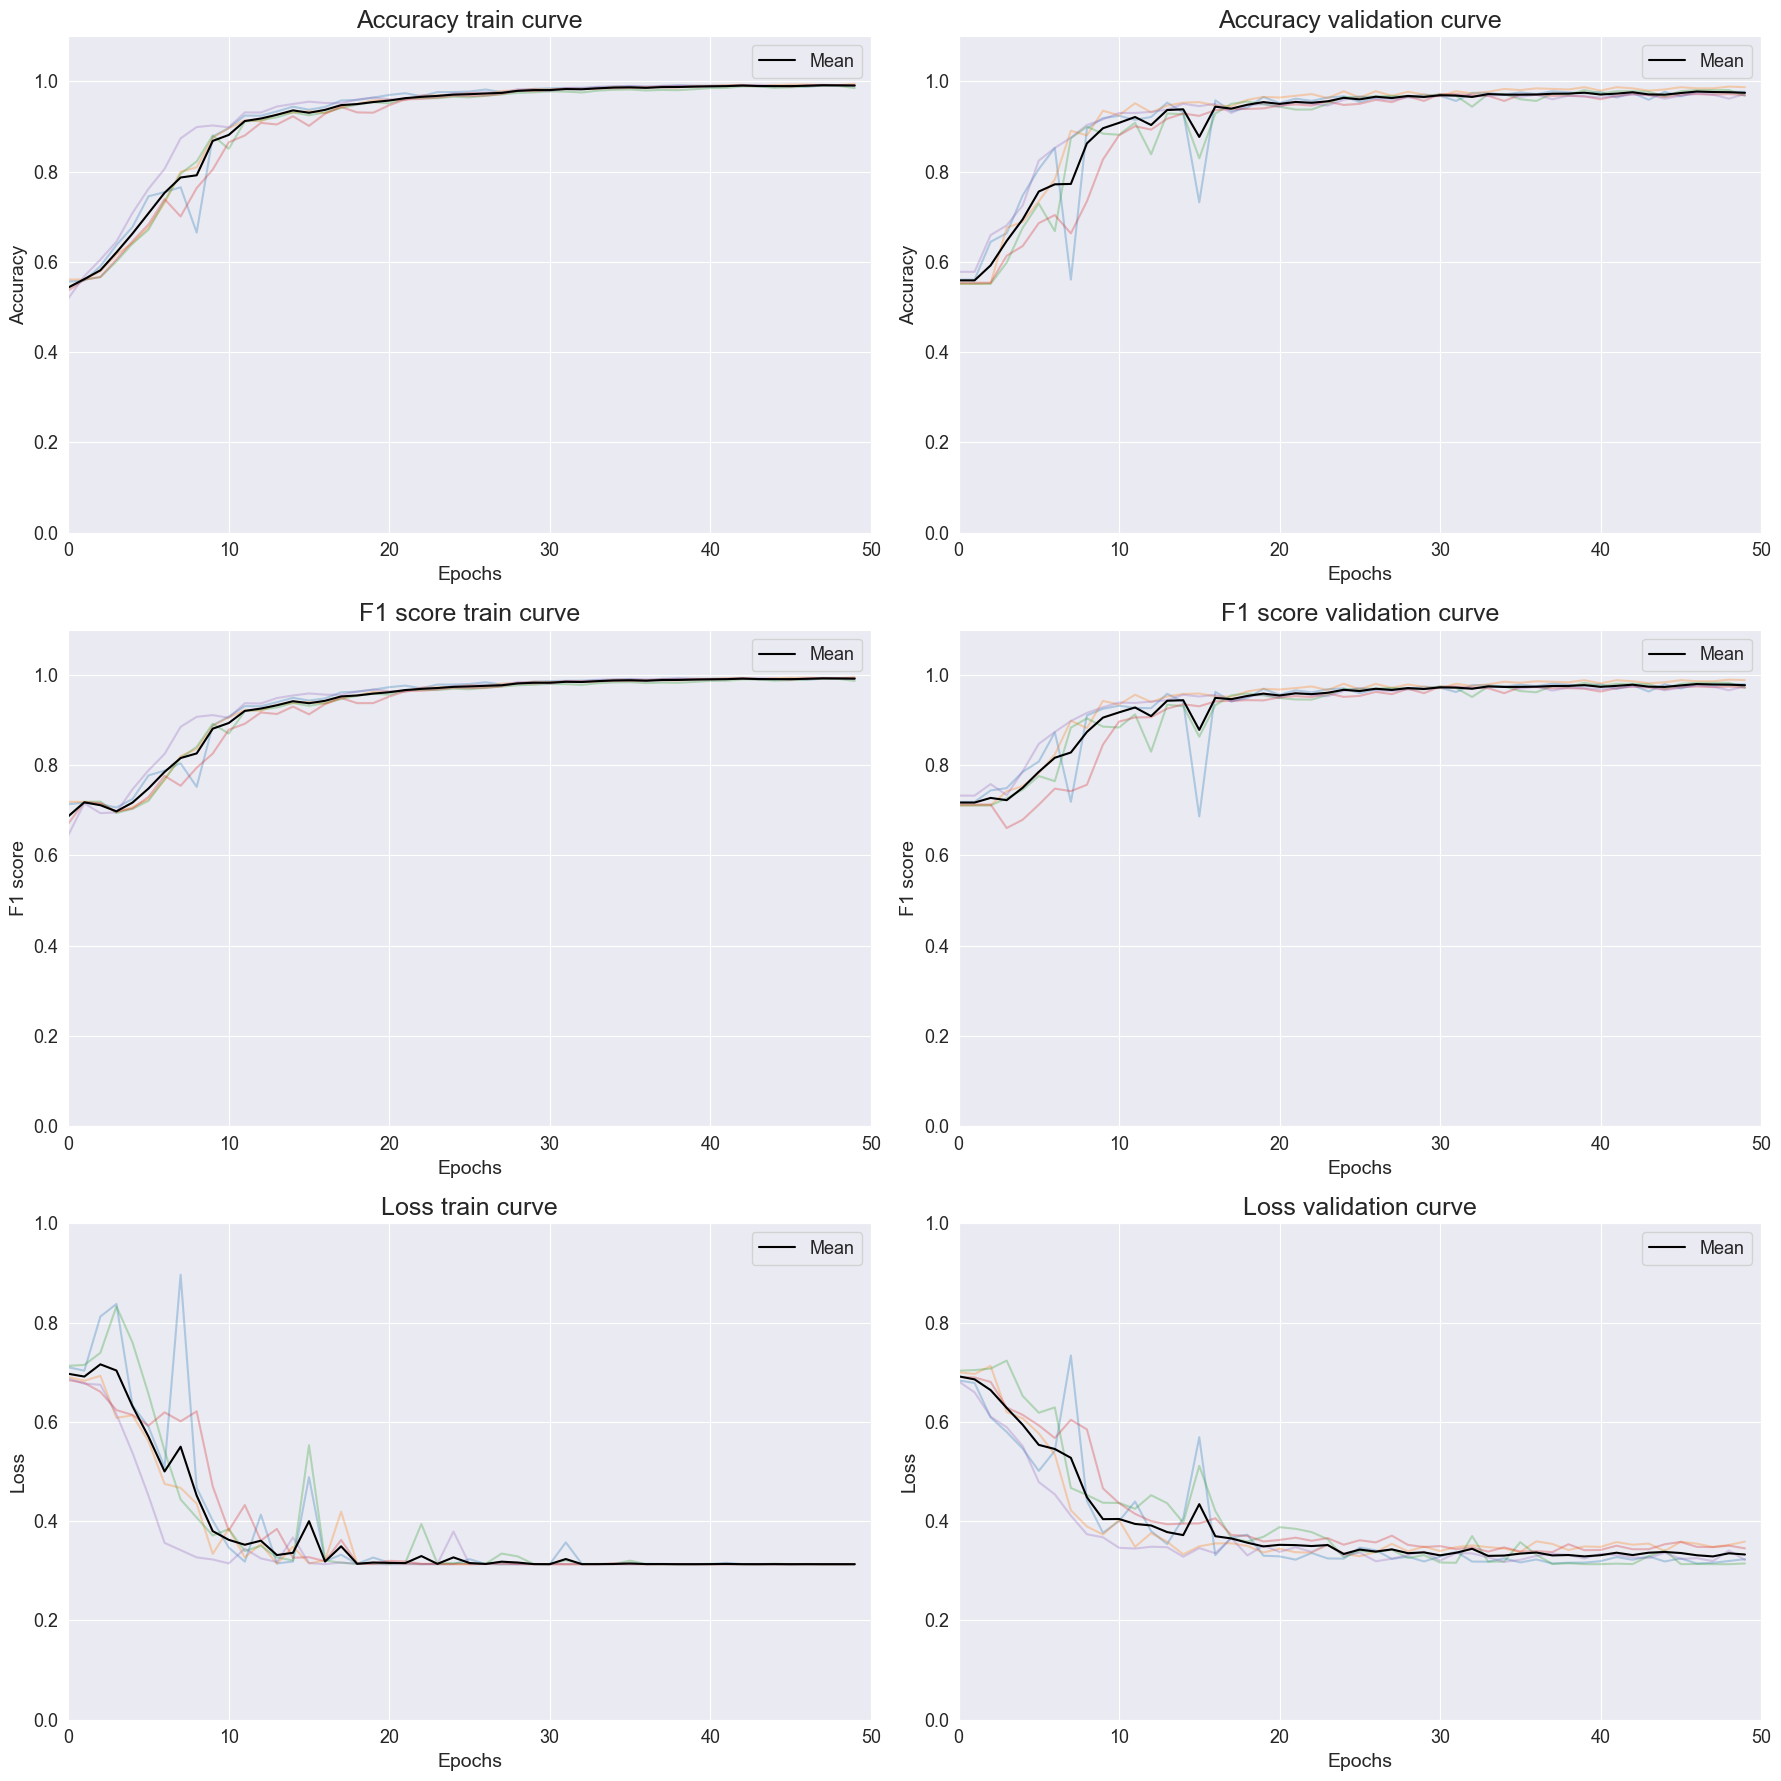

In [16]:

fig, axs = plt.subplots(3, 2, figsize=(18, 18))
#plot all the accuracy train in trasparency curves and the mean curve in highlighted
for i in range(len(data['acc_train'].values)):
    axs[0][0].plot(list(range(len(data['acc_train'].values[i]))), [pt for pt in data['acc_train'].values[i]], alpha=0.3)
axs[0][0].plot(list(range(len(data['acc_train'].values[i]))), [float(sum(col))/len(col) for col in zip(*data['acc_train'])], label='Mean', color='black')
axs[0][0].set_xlabel('Epochs')
axs[0][0].set_ylabel('Accuracy')
axs[0][0].set_title('Accuracy train curve')
axs[0][0].set_ylim(0,1.1)
axs[0][0].set_xlim(0,50)
axs[0][0].legend()


#plot all the accuracy validation in trasparency curves and the mean curve in highlighted
for i in range(len(data['acc_val'].values)):
    axs[0][1].plot(list(range(len(data['acc_val'].values[i]))), [pt for pt in data['acc_val'].values[i]], alpha=0.3)
axs[0][1].plot(list(range(len(data['acc_val'].values[i]))), [float(sum(col))/len(col) for col in zip(*data['acc_val'])], label='Mean', color='black')
axs[0][1].set_xlabel('Epochs')
axs[0][1].set_ylabel('Accuracy')
axs[0][1].set_title('Accuracy validation curve')
axs[0][1].set_ylim(0,1.1)
axs[0][1].set_xlim(0,50)
axs[0][1].legend()

#plot all the f1 train in trasparency curves and the mean curve in highlighted
for i in range(len(data['f1_train'].values)):
    axs[1][0].plot(list(range(len(data['f1_train'].values[i]))), [pt for pt in data['f1_train'].values[i]], alpha=0.3)
axs[1][0].plot(list(range(len(data['f1_train'].values[i]))), [float(sum(col))/len(col) for col in zip(*data['f1_train'])], label='Mean', color='black')
axs[1][0].set_xlabel('Epochs')
axs[1][0].set_ylabel('F1 score')
axs[1][0].set_title('F1 score train curve')
axs[1][0].set_ylim(0,1.1)
axs[1][0].set_xlim(0,50)
axs[1][0].legend()

#plot all the f1 validation in trasparency curves and the mean curve in highlighted
for i in range(len(data['f1_val'].values)):
    axs[1][1].plot(list(range(len(data['f1_val'].values[i]))), [pt for pt in data['f1_val'].values[i]], alpha=0.3)
axs[1][1].plot(list(range(len(data['f1_val'].values[i]))), [float(sum(col))/len(col) for col in zip(*data['f1_val'])], label='Mean', color='black')
axs[1][1].set_xlabel('Epochs')
axs[1][1].set_ylabel('F1 score')
axs[1][1].set_title('F1 score validation curve')
axs[1][1].set_ylim(0,1.1)
axs[1][1].set_xlim(0,50)
axs[1][1].legend()

#plot all the loss train in trasparency curves and the mean curve in highlighted
for i in range(len(data['loss_train'].values)):
    axs[2][0].plot(list(range(len(data['loss_train'].values[i]))), [pt for pt in data['loss_train'].values[i]], alpha=0.3)
axs[2][0].plot(list(range(len(data['loss_train'].values[i]))), [float(sum(col))/len(col) for col in zip(*data['loss_train'])], label='Mean', color='black')
axs[2][0].set_xlabel('Epochs')
axs[2][0].set_ylabel('Loss')
axs[2][0].set_title('Loss train curve')
axs[2][0].set_ylim(0,1)
axs[2][0].set_xlim(0,50)
axs[2][0].legend()

#plot all the loss validation in trasparency curves and the mean curve in highlighted
for i in range(len(data['loss_val'].values)):
    axs[2][1].plot(list(range(len(data['loss_val'].values[i]))), [pt for pt in data['loss_val'].values[i]], alpha=0.3)
axs[2][1].plot(list(range(len(data['loss_val'].values[i]))), [float(sum(col))/len(col) for col in zip(*data['loss_val'])], label='Mean', color='black')
axs[2][1].set_xlabel('Epochs')
axs[2][1].set_ylabel('Loss')
axs[2][1].set_title('Loss validation curve')
axs[2][1].set_ylim(0,1)
axs[2][1].set_xlim(0,50)
axs[2][1].legend()

plt.savefig("model/rgb/"+'CNN_trained_'+str(num_epochs)+'epoch'+now+'.png')
plt.tight_layout()
plt.show()

In [ ]:
# mean_accuracy = np.mean(np.array(acc_val_tot)[:,num_epochs-1])
# mean_f1 = np.mean(np.array(f1_val_tot)[:,num_epochs-1])
# mean_loss = np.mean(np.array(losses_val_tot)[:,num_epochs-1])

# fig, axs = plt.subplots(3, 2, figsize=(18, 18))

# # Plot accuracy train curve
# for i in range(len(data['acc_train'].values)):
#     axs[0][0].plot(list(range(len(data['acc_train'].values[i]))), [pt for pt in data['acc_train'].values[i]], label='fold '+str(i+1))
# axs[0][0].set_xlabel('Epochs')
# axs[0][0].set_ylabel('Accuracy')
# axs[0][0].set_title("Accuracy train curve")
# axs[0][0].legend()

# # Plot accuracy validation curve
# for i in range(len(data['acc_val'].values)):
#     axs[0][1].plot(list(range(len(data['acc_val'].values[i]))), [pt for pt in data['acc_val'].values[i]], label='fold '+str(i+1))
# axs[0][1].set_xlabel('Epochs')
# axs[0][1].set_ylabel('Accuracy')
# axs[0][1].set_title("Accuracy validation curve")
# axs[0][1].legend()

# # Plot f1 train curve 
# for i in range(len(data['f1_train'].values)):
#     axs[1][0].plot(list(range(len(data['f1_train'].values[i]))), [pt for pt in data['f1_train'].values[i]], label='fold '+str(i+1))
# axs[1][0].set_xlabel('Epochs')
# axs[1][0].set_ylabel('F1 score')
# axs[1][0].set_title("F1 score train curve")
# axs[1][0].legend()

# # Plot f1 validation curve
# for i in range(len(data['f1_val'].values)):
#     axs[1][1].plot(list(range(len(data['f1_val'].values[i]))), [pt for pt in data['f1_val'].values[i]], label='fold '+str(i+1))
# axs[1][1].set_xlabel('Epochs')
# axs[1][1].set_ylabel('F1 score')
# axs[1][1].set_title("F1 score validation curve")
# axs[1][1].legend()

# # Plot loss train curve
# for i in range(len(data['loss_train'].values)):
#     axs[2][0].plot(list(range(len(data['loss_train'].values[i]))), [pt for pt in data['loss_train'].values[i]], label='fold '+str(i+1))
# axs[2][0].set_xlabel('Epochs')
# axs[2][0].set_ylabel('Loss')
# axs[2][0].set_title("Loss train curve")
# axs[2][0].legend()

# # Plot loss validation curve
# for i in range(len(data['loss_val'].values)):
#     axs[2][1].plot(list(range(len(data['loss_val'].values[i]))), [pt for pt in data['loss_val'].values[i]], label='fold '+str(i+1))
# axs[2][1].set_xlabel('Epochs')
# axs[2][1].set_ylabel('Loss')
# axs[2][1].set_title("Loss validation curve")
# axs[2][1].legend()




# plt.savefig("model/rgb/"+'CNN_trained_'+str(num_epochs)+'epoch'+now+'.png')
# plt.tight_layout()
# plt.show()


### CNN Test

f1: 0.9911816578483245
Accuracy: 0.990



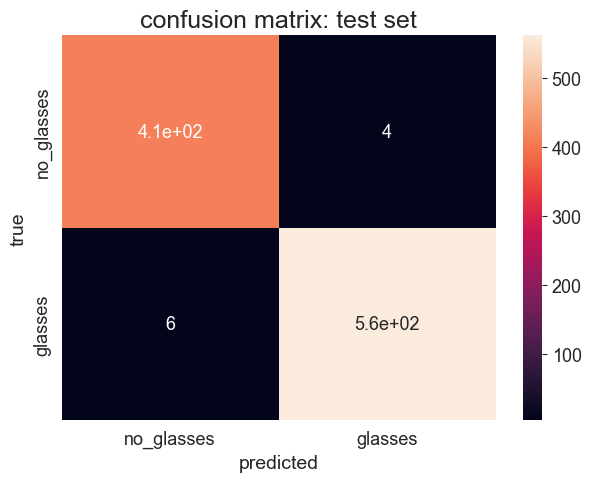

In [10]:
n_classes =  len(np.unique(y_test))   
lab_classes = ['no_glasses','glasses']

# Load the best model across all folds
model_test_CNN = CNN_128x128(input_channel=3,num_classes=n_classes).to(device)      
#model_test_CNN.load_state_dict(torch.load(best_model_path))  
model_test_CNN.load_state_dict(torch.load(r'model\rgb\CNN_model_fold_2_trained_50epoch_validation_accuracy_0.9872935196950444.pt'))  

# Create test set
test_set = CustomDataset(X_test,y_test)
test_loader = DataLoader(test_set, batch_size=1)


pred_label_test = torch.empty((0,n_classes)).to(device)
true_label_test = torch.empty((0)).to(device)

model_test_CNN.eval()

with torch.no_grad():
  for data in test_loader:
    X_te, y_te = data
    b,_,_,_ = X_te.shape
    X_te = X_te.view(b,3,128,128).float().to(device)
    y_te = y_te.to(device)
    output_test = model_test_CNN(X_te)
    pred_label_test = torch.cat((pred_label_test,output_test),dim=0)
    true_label_test = torch.cat((true_label_test,y_te),dim=0)

# Compute metrics
print("f1:",f1_score(true_label_test.cpu(), pred_label_test.cpu().argmax(dim=1).cpu(), average='binary'))
compute_metrics(y_true=true_label_test,y_pred=pred_label_test,lab_classes=lab_classes)    

### kernel

Total convolution layers: 3


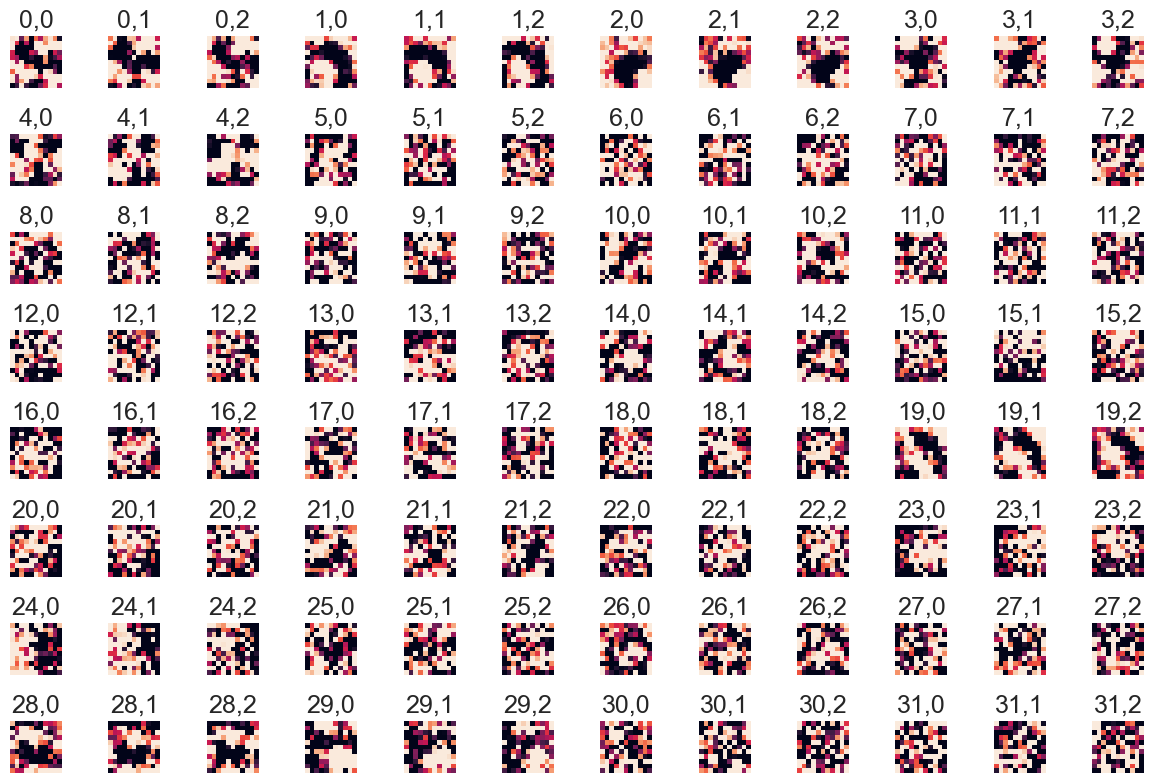

In [12]:

model_weights,conv_layers = [], []
model_children = list(model_test_CNN.children())
counter = 0

for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)

print(f"Total convolution layers: {counter}")

# Visualize the model weights
plot_weights(model_weights[0].detach().cpu(), single_channel = True, collated = False)


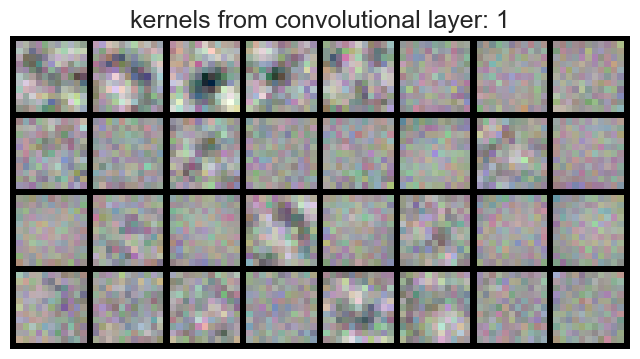

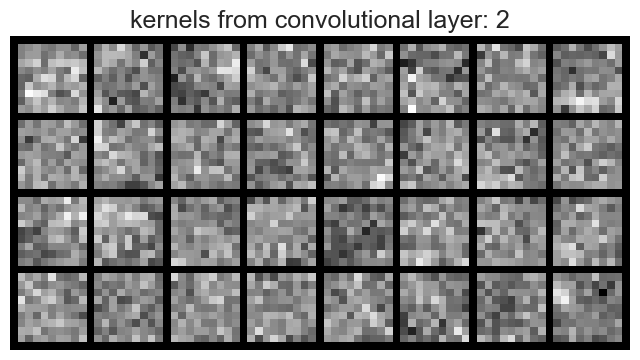

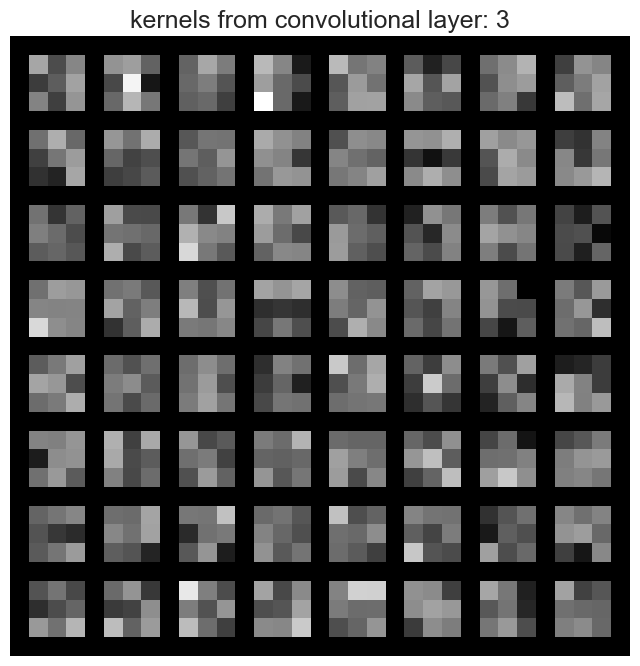

In [19]:
#kernels_1 = model_test_CNN.conv1.weight.data.cpu().clone()
visTensor(model_weights[0].detach().cpu(), ch=1, allkernels=False)
plt.axis('off')
plt.title('kernels from convolutional layer: 1')
plt.ioff()
plt.show()

# Get the second kernel from the model
#kernels_2 = model_test_CNN.conv2.weight.data.cpu().clone()
visTensor(model_weights[1].detach().cpu(), ch=0, allkernels=False)
plt.axis('off')
plt.title('kernels from convolutional layer: 2')
plt.ioff()
plt.show()

# Get the second kernel from the model
#kernels_3 = model_test_CNN.conv3.weight.data.cpu().clone()
visTensor(model_weights[2].detach().cpu(), ch=0, allkernels=False)
plt.axis('off')
plt.title('kernels from convolutional layer: 3')
plt.ioff()
plt.show()


c:\Users\enric\anaconda3\envs\expCUDA\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


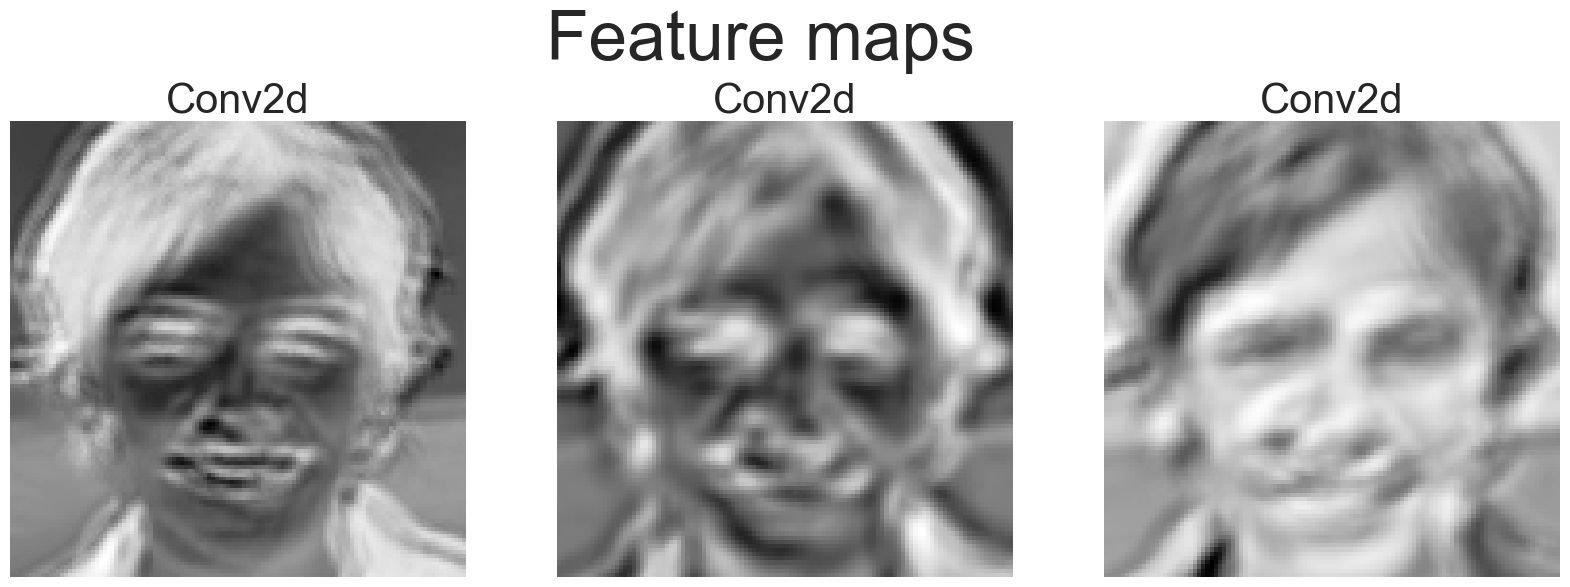

In [13]:
image= Image.open(r'archive_488\Images\Images\no_glasses\face-30.jpg').convert('RGB')
image = preprocess(image).unsqueeze(0).to(device)

outputs, names,processed = [], [], []

# Pass the image through all the layers
for layer in conv_layers[0:]:   
    image = layer(image)        
    outputs.append(image)       
    names.append(str(layer))  

# Save the feature maps from each layer
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
    
# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
for i in range(3):
    axs[i].imshow(processed[i],cmap='Greys')
    axs[i].set_title(names[i].split('(')[0], fontsize=30)
    axs[i].axis('off')
fig.suptitle('Feature maps', fontsize=50)
plt.show()


# Scatnet

In [22]:
# Clearing memory
gc.collect()
torch.cuda.empty_cache()

scattering = Scattering2D(J=2, L=8, shape=(128,128)).to(device) 
# J: Log-2 of the scattering scale, 
# L: Number of angles used for the wavelet transform 
# shape: shape of the input image

kf = KFold(n_splits=5, shuffle=True, random_state=42) # Splitting data into 5 folds for training and validation

#---------------------------------------
num_epochs = 100    # number of epochs 
lr = 0.005        # learning rate 0.00001
momentum = 0.0     # momentum
#---------------------------------------

best_acc, best_f1 = 0.0, 0.0
acc_train_tot, f1_train_tot, acc_val_tot, f1_val_tot,losses_train_tot,losses_val_tot = [], [], [], [], [], []
model_kf = 0
# Training and validation loop
for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    del model_kf
    
    train_dataset = CustomDataset(np.array(X_train)[train_index],y_train[train_index])   
    test_dataset = CustomDataset(np.array(X_train)[val_index],y_train[val_index])  
 
    train_loader = DataLoader(train_dataset, batch_size=128)
    val_loader = DataLoader(test_dataset, batch_size=128)
    model_kf = ScatNet2D(input_channels=81, scattering=scattering).to(device)

    #optimizer = torch.optim.Adam(model_kf.parameters(), lr=lr, weight_decay=0.03) #Adam optimizer
    optimizer = torch.optim.SGD(model_kf.parameters(),lr = lr, momentum=momentum)

    criterion_kf = torch.nn.CrossEntropyLoss()  
    
    acc_train_fold, f1_train_fold, acc_val_fold, f1_val_fold, losses_train_fold, losses_val_fold = [], [], [], [], [], []

    # Epoch loop
    for epoch in (pbar := tqdm(range(num_epochs))):
        model_kf.train()
        pred_label_test = torch.empty((0)).to(device)    
        true_label_test = torch.empty((0)).to(device)
        pred_label_train = torch.empty((0)).to(device)    
        true_label_train = torch.empty((0)).to(device)

        # Training loop
        for data_tr in train_loader:
            inputs, labels = data_tr
            batch,_,_,_ = inputs.shape
            inputs = inputs.view(batch,3,128,128).float().to(device)  
            labels = labels.to(device)
            output_kf = model_kf(inputs)
            _, predict = output_kf.max(1)
            pred_label_train = torch.cat((pred_label_train,predict),dim=0)
            true_label_train = torch.cat((true_label_train,labels),dim=0)
            optimizer.zero_grad()
            loss = criterion_kf(output_kf, labels)
            loss.backward()
            optimizer.step()
            
        losses_train_fold.append(loss.item())
        acc_train_ep = accuracy_score(true_label_train.cpu(),pred_label_train.cpu())
        acc_train_fold.append(acc_train_ep)
        f1_train_ep = f1_score(true_label_train.cpu(), pred_label_train.cpu(), average='binary')
        f1_train_fold.append(f1_train_ep)


        # Evaluation loop
        model_kf.eval()
        with torch.no_grad():
            for data_ts in val_loader:
                inputs, labels = data_ts
                b,_,_,_ = inputs.shape
                inputs = inputs.view(b,3,128,128).float().to(device)
                labels = labels.to(device)
                output_kf = model_kf(inputs)
                _, predicted = output_kf.max(1)
                loss_val = criterion_kf(output_kf, labels)
                pred_label_test = torch.cat((pred_label_test,predicted),dim=0)
                true_label_test = torch.cat((true_label_test,labels),dim=0)   
        losses_val_fold.append(loss_val.item())     
        f1_val_ep = f1_score(true_label_test.cpu(), pred_label_test.cpu(), average='binary')
        f1_val_fold.append(f1_val_ep)
        acc_val_ep = accuracy_score(true_label_test.cpu(),pred_label_test.cpu())
        acc_val_fold.append(acc_val_ep)  
        pbar.set_description(f"Fold{fold+1}| loss_tr: {loss.item():.4f} - loss_ev: {loss_val.item():.4f}| acc_tr: {acc_train_ep*100:.2f}% - acc_ev: {acc_val_ep*100:.2f}%| f1_tr: {f1_train_ep:.4f} - f1_ev: {f1_val_ep:.4f}| lr: {lr:.6f}")

    acc_train_tot.append(acc_train_fold)
    f1_train_tot.append(f1_train_fold)

    acc_val_tot.append(acc_val_fold)
    f1_val_tot.append(f1_val_fold)
    
    losses_train_tot.append(losses_train_fold)
    losses_val_tot.append(losses_val_fold)

    
    torch.save(model_kf.state_dict(),"model/rgb/"+'ScatNet_model_dict_'+"fold_"+str(fold+1)+'_trained_'+str(num_epochs)+'epoch'+"_validation_accuracy_"+str(acc_val_ep)+"_momentum"+str(momentum)+'_.pt')
    if acc_val_ep > best_acc:        
        best_model_path = models_trained_path+'ScatNet_RGB_best_model_trained_'+str(num_epochs)+'epoch'+"_validation_accuracy_"+str(acc_val_ep)+"_momentum"+str(momentum)+'_.pt'                                                    
        torch.save(model_kf.state_dict(), best_model_path)
        best_acc = acc_val_ep
        print("save")
    
    del optimizer
    del criterion_kf
    torch.cuda.empty_cache()
print(f"Mean f1 score: {np.mean(np.array(f1_val_tot)[:,num_epochs-1]):.4f}")
print(f"Mean accuracy: {np.mean(np.array(acc_val_tot)[:,num_epochs-1])* 100:.2f}%")
print(f"Mean loss: {np.mean(np.array(losses_val_tot)[:,num_epochs-1]):.4f}")
now = time.strftime("%Y-%m-%d_%H-%M-%S")
data = pd.DataFrame(columns=['f1_train','f1_val','acc_train','acc_val','loss_train','loss_val','num_epoch'])
data['f1_train'] = f1_train_tot
data['f1_val'] = f1_val_tot
data['acc_train'] = acc_train_tot
data['acc_val'] = acc_val_tot
data['loss_train'] = losses_train_tot
data['loss_val'] = losses_val_tot
data['num_epoch'] = num_epochs
data.to_csv('model/'+'ScatNet_model_training_'+str(num_epochs)+'epoch_'+now+'.csv', index=False)

Fold1| loss_tr: 0.4370 - loss_ev: 0.3797| acc_tr: 91.01% - acc_ev: 89.59%| f1_tr: 0.9191 - f1_ev: 0.9111| lr: 0.005000: 100%|██████████| 100/100 [12:24<00:00,  7.45s/it]


save


Fold2| loss_tr: 0.4769 - loss_ev: 0.6212| acc_tr: 89.58% - acc_ev: 83.35%| f1_tr: 0.9062 - f1_ev: 0.8683| lr: 0.005000: 100%|██████████| 100/100 [12:50<00:00,  7.71s/it]
Fold3| loss_tr: 0.4314 - loss_ev: 0.4194| acc_tr: 92.16% - acc_ev: 86.66%| f1_tr: 0.9290 - f1_ev: 0.8891| lr: 0.005000: 100%|██████████| 100/100 [12:54<00:00,  7.75s/it]
Fold4| loss_tr: 0.4170 - loss_ev: 0.3958| acc_tr: 92.19% - acc_ev: 86.53%| f1_tr: 0.9296 - f1_ev: 0.8850| lr: 0.005000: 100%|██████████| 100/100 [12:55<00:00,  7.75s/it]
Fold5| loss_tr: 0.4274 - loss_ev: 0.4613| acc_tr: 90.31% - acc_ev: 89.07%| f1_tr: 0.9123 - f1_ev: 0.9089| lr: 0.005000: 100%|██████████| 100/100 [12:54<00:00,  7.75s/it]


Mean f1 score: 0.8925
Mean accuracy: 87.04%
Mean loss: 0.4555


+--------+------------+--------------+------------------+--------------------+--------------+----------------+
| Fold   |   F1 (Val) |   F1 (Train) |   Accuracy (Val) |   Accuracy (Train) |   Loss (Val) |   Loss (Train) |
+========+============+==============+==================+====================+==============+================+
| fold 1 |   0.83881  |     0.841612 |         0.818376 |           0.811096 |     0.493674 |       0.520071 |
+--------+------------+--------------+------------------+--------------------+--------------+----------------+
| fold 2 |   0.823646 |     0.830099 |         0.777344 |           0.794614 |     0.652871 |       0.52875  |
+--------+------------+--------------+------------------+--------------------+--------------+----------------+
| fold 3 |   0.841213 |     0.843457 |         0.809009 |           0.812833 |     0.507054 |       0.511987 |
+--------+------------+--------------+------------------+--------------------+--------------+----------------+
|

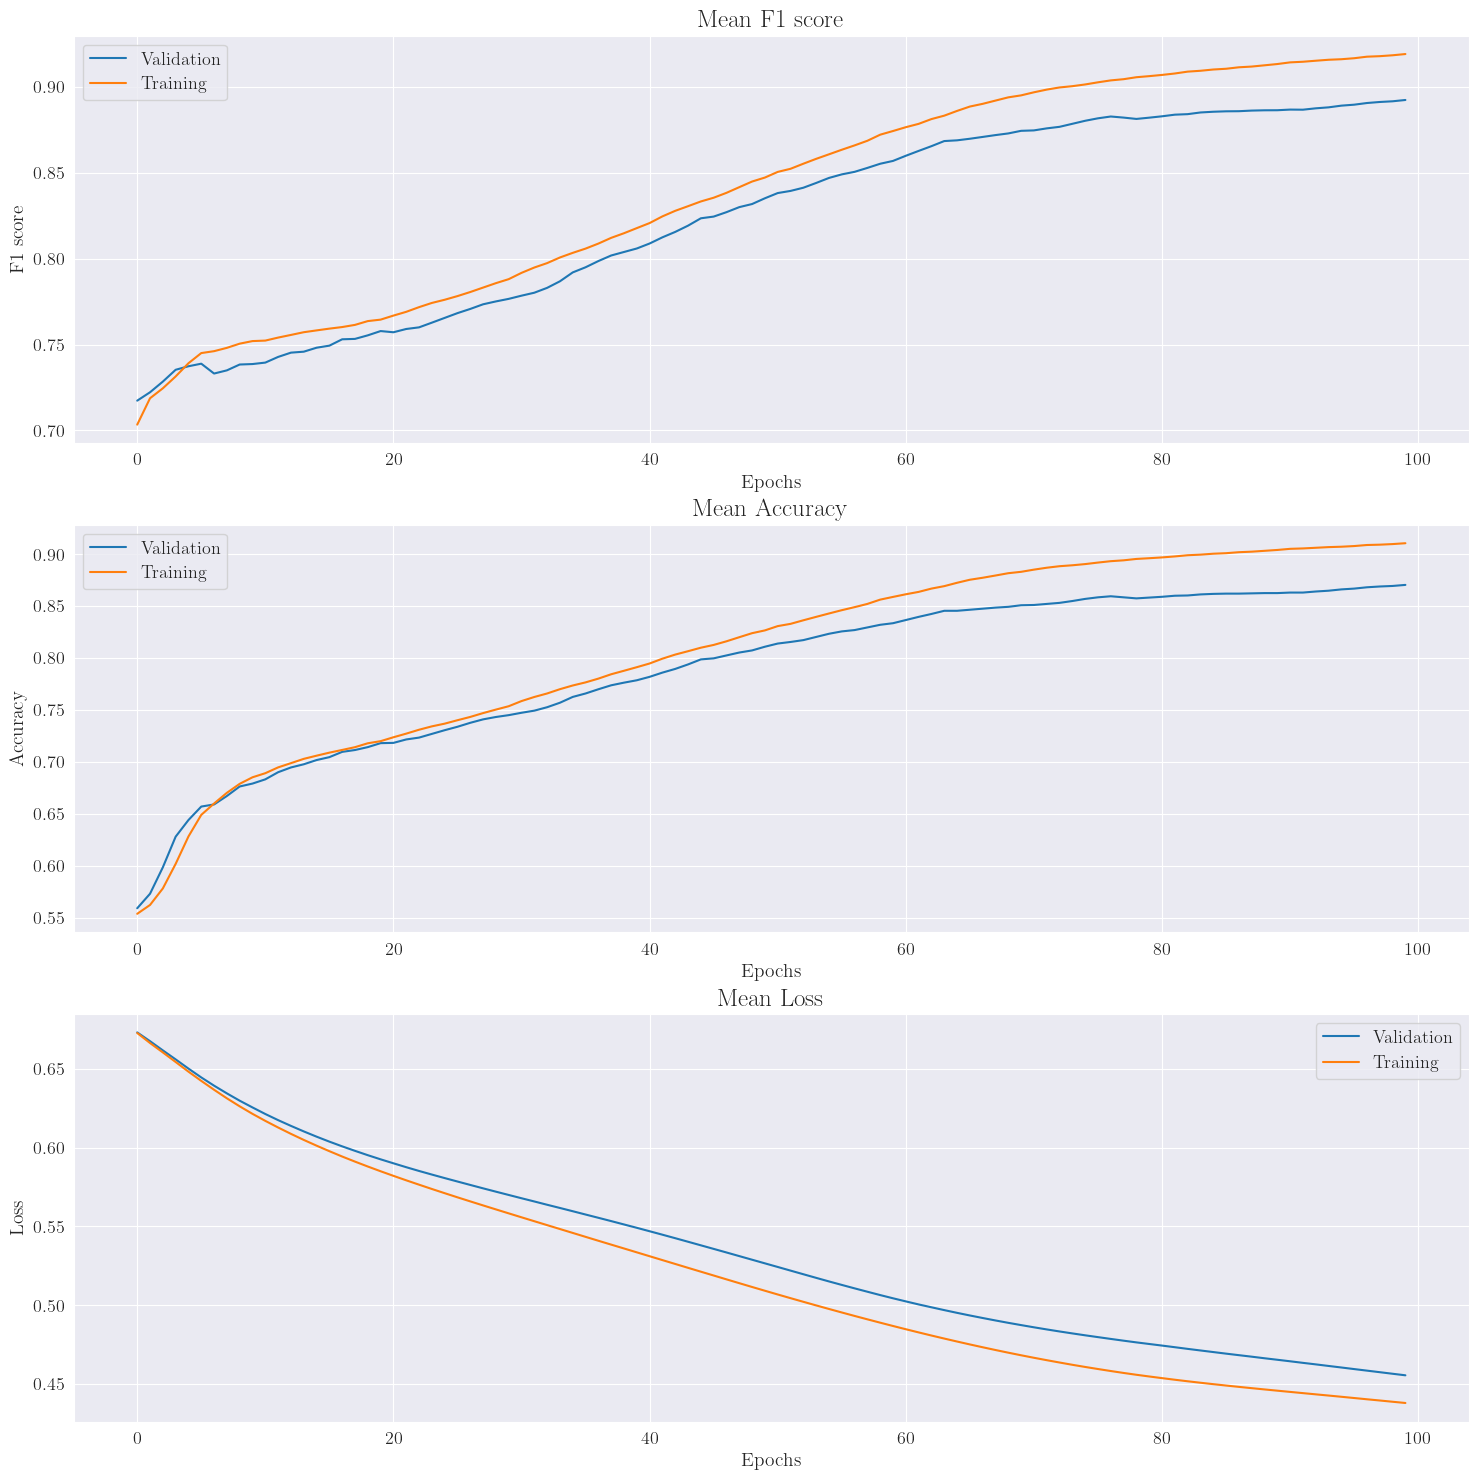

In [16]:
now = time.strftime("%Y-%m-%d_%H-%M-%S")
name = 'ScatNet_model_training_100epoch_2024-03-02_13-51-38'
data, num_epochs = process_csv_file('model/'+ name +'.csv')

mean_lists = {
    'Fold': ["fold 1","fold 2","fold 3","fold 4","fold 5"],
    'F1 (Val)': [np.mean(data['f1_val'][i]) for i in range(len(data['f1_val']))],
    'F1 (Train)': [np.mean(data['f1_train'][i]) for i in range(len(data['f1_train']))],
    'Accuracy (Val)': [np.mean(data['acc_val'][i]) for i in range(len(data['acc_val']))],
    'Accuracy (Train)': [np.mean(data['acc_train'][i]) for i in range(len(data['acc_train']))],
    'Loss (Val)': [np.mean(data['loss_val'][i]) for i in range(len(data['loss_val']))],
    'Loss (Train)': [np.mean(data['loss_train'][i]) for i in range(len(data['loss_train']))]
}
table = tabulate(mean_lists, headers='keys', tablefmt='grid')
print(table)
                                    

fig, ax = plt.subplots(3, 1, figsize=(18, 18))

ax[0].plot([float(sum(col))/len(col) for col in zip(*data['f1_val'])], label='Validation')
ax[0].plot([float(sum(col))/len(col) for col in zip(*data['f1_train'])], label='Training')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('F1 score')
ax[0].set_title('Mean F1 score')
ax[0].legend()

ax[1].plot([float(sum(col))/len(col) for col in zip(*data['acc_val'])], label='Validation')
ax[1].plot([float(sum(col))/len(col) for col in zip(*data['acc_train'])], label='Training')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Mean Accuracy')
ax[1].legend()

ax[2].plot([float(sum(col))/len(col) for col in zip(*data['loss_val'])], label='Validation')
ax[2].plot([float(sum(col))/len(col) for col in zip(*data['loss_train'])], label='Training')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].set_title('Mean Loss')
ax[2].legend()

plt.show()


In [ ]:
# fig, axs = plt.subplots(3, 2, figsize=(18, 18))

# # Plot accuracy train curve
# for i in range(len(data['acc_train'].values)):
#     axs[0][0].plot(list(range(len(data['acc_train'].values[i]))), [pt for pt in data['acc_train'].values[i]], label='fold '+str(i+1))
# axs[0][0].set_xlabel('Epochs')
# axs[0][0].set_ylabel('Accuracy')
# axs[0][0].set_title("Accuracy train curve")
# axs[0][0].legend()

# # Plot accuracy validation curve
# for i in range(len(data['acc_val'].values)):
#     axs[0][1].plot(list(range(len(data['acc_val'].values[i]))), [pt for pt in data['acc_val'].values[i]], label='fold '+str(i+1))
# axs[0][1].set_xlabel('Epochs')
# axs[0][1].set_ylabel('Accuracy')
# axs[0][1].set_title("Accuracy validation curve")
# axs[0][1].legend()

# # Plot f1 train curve 
# for i in range(len(data['f1_train'].values)):
#     axs[1][0].plot(list(range(len(data['f1_train'].values[i]))), [pt for pt in data['f1_train'].values[i]], label='fold '+str(i+1))
# axs[1][0].set_xlabel('Epochs')
# axs[1][0].set_ylabel('F1 score')
# axs[1][0].set_title("F1 score train curve")
# axs[1][0].legend()

# # Plot f1 validation curve
# for i in range(len(data['f1_val'].values)):
#     axs[1][1].plot(list(range(len(data['f1_val'].values[i]))), [pt for pt in data['f1_val'].values[i]], label='fold '+str(i+1))
# axs[1][1].set_xlabel('Epochs')
# axs[1][1].set_ylabel('F1 score')
# axs[1][1].set_title("F1 score validation curve")
# axs[1][1].legend()

# # Plot loss train curve
# for i in range(len(data['loss_train'].values)):
#     axs[2][0].plot(list(range(len(data['loss_train'].values[i]))), [pt for pt in data['loss_train'].values[i]], label='fold '+str(i+1))
# axs[2][0].set_xlabel('Epochs')
# axs[2][0].set_ylabel('Loss')
# axs[2][0].set_title("Loss train curve")
# axs[2][0].legend()

# # Plot loss validation curve
# for i in range(len(data['loss_val'].values)):
#     axs[2][1].plot(list(range(len(data['loss_val'].values[i]))), [pt for pt in data['loss_val'].values[i]], label='fold '+str(i+1))
# axs[2][1].set_xlabel('Epochs')
# axs[2][1].set_ylabel('Loss')
# axs[2][1].set_title("Loss validation curve")
# axs[2][1].legend()




# plt.savefig("model/rgb/"+'ScatNet_trained_'+str(num_epochs)+'epoch_'+"momentum"+str(momentum)+"_"+now+'_.png')
# plt.tight_layout()
# plt.show()

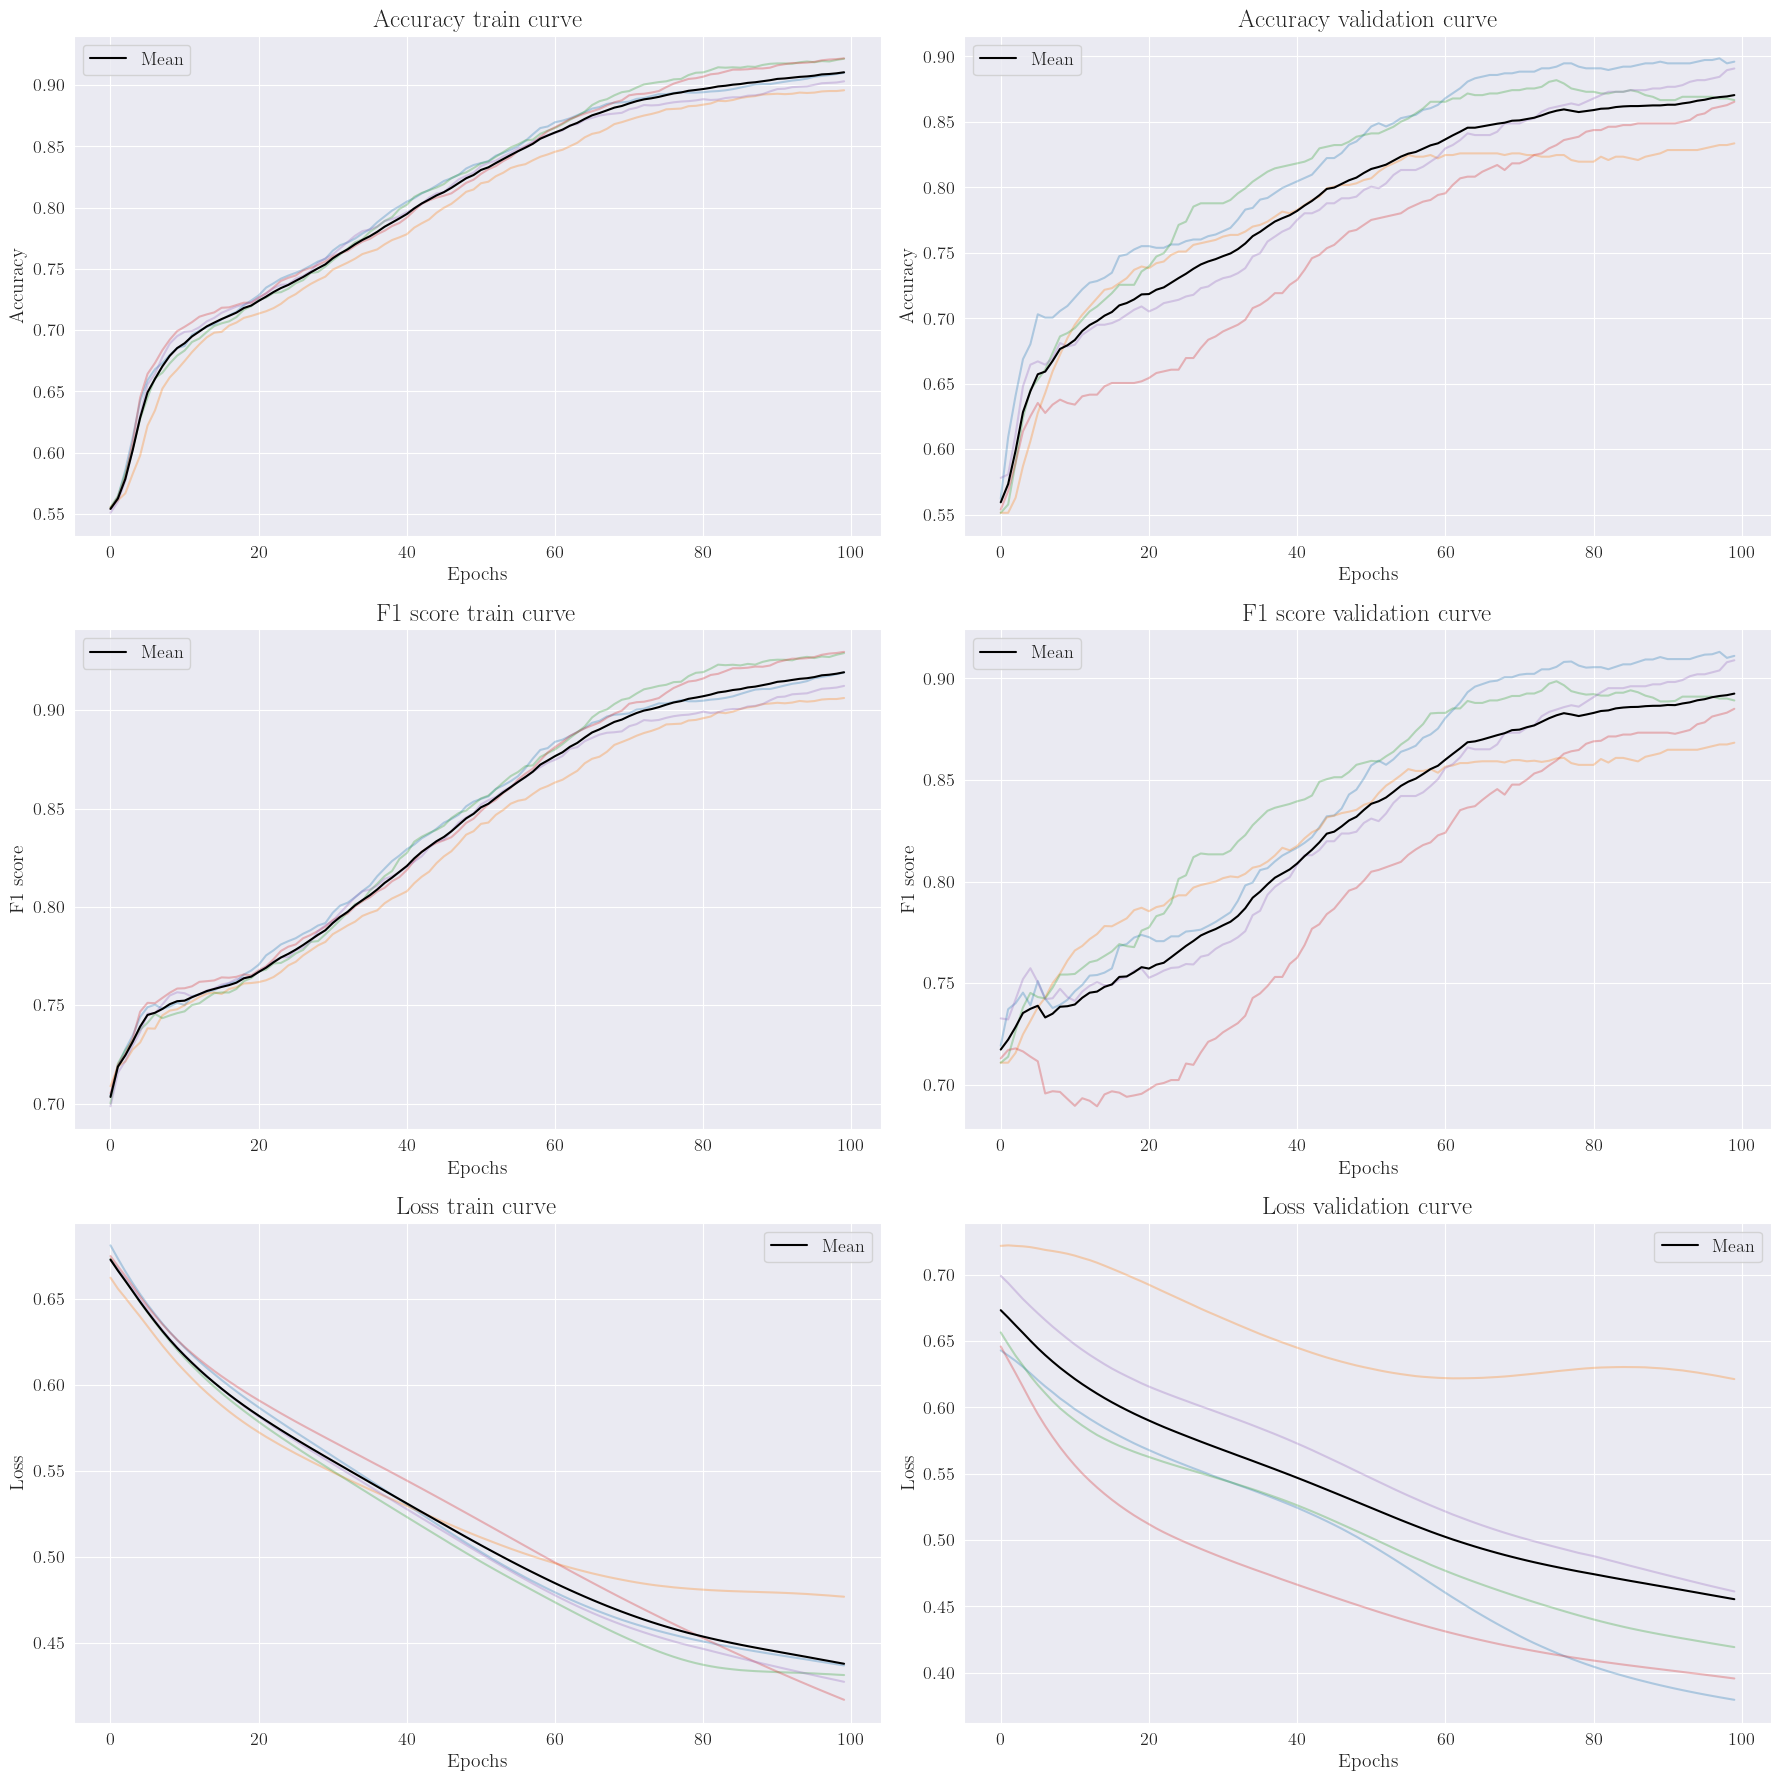

In [17]:
fig, axs = plt.subplots(3, 2, figsize=(18, 18))
#plot all the accuracy train in trasparency curves and the mean curve in highlighted
for i in range(len(data['acc_train'].values)):
    axs[0][0].plot(list(range(len(data['acc_train'].values[i]))), [pt for pt in data['acc_train'].values[i]], alpha=0.3)
axs[0][0].plot(list(range(len(data['acc_train'].values[i]))), [float(sum(col))/len(col) for col in zip(*data['acc_train'])], label='Mean', color='black')
axs[0][0].set_xlabel('Epochs')
axs[0][0].set_ylabel('Accuracy')
axs[0][0].set_title('Accuracy train curve')
axs[0][0].legend()


#plot all the accuracy validation in trasparency curves and the mean curve in highlighted
for i in range(len(data['acc_val'].values)):
    axs[0][1].plot(list(range(len(data['acc_val'].values[i]))), [pt for pt in data['acc_val'].values[i]], alpha=0.3)
axs[0][1].plot(list(range(len(data['acc_val'].values[i]))), [float(sum(col))/len(col) for col in zip(*data['acc_val'])], label='Mean', color='black')
axs[0][1].set_xlabel('Epochs')
axs[0][1].set_ylabel('Accuracy')
axs[0][1].set_title('Accuracy validation curve')
axs[0][1].legend()

#plot all the f1 train in trasparency curves and the mean curve in highlighted
for i in range(len(data['f1_train'].values)):
    axs[1][0].plot(list(range(len(data['f1_train'].values[i]))), [pt for pt in data['f1_train'].values[i]], alpha=0.3)
axs[1][0].plot(list(range(len(data['f1_train'].values[i]))), [float(sum(col))/len(col) for col in zip(*data['f1_train'])], label='Mean', color='black')
axs[1][0].set_xlabel('Epochs')
axs[1][0].set_ylabel('F1 score')
axs[1][0].set_title('F1 score train curve')
axs[1][0].legend()

#plot all the f1 validation in trasparency curves and the mean curve in highlighted
for i in range(len(data['f1_val'].values)):
    axs[1][1].plot(list(range(len(data['f1_val'].values[i]))), [pt for pt in data['f1_val'].values[i]], alpha=0.3)
axs[1][1].plot(list(range(len(data['f1_val'].values[i]))), [float(sum(col))/len(col) for col in zip(*data['f1_val'])], label='Mean', color='black')
axs[1][1].set_xlabel('Epochs')
axs[1][1].set_ylabel('F1 score')
axs[1][1].set_title('F1 score validation curve')
axs[1][1].legend()

#plot all the loss train in trasparency curves and the mean curve in highlighted
for i in range(len(data['loss_train'].values)):
    axs[2][0].plot(list(range(len(data['loss_train'].values[i]))), [pt for pt in data['loss_train'].values[i]], alpha=0.3)
axs[2][0].plot(list(range(len(data['loss_train'].values[i]))), [float(sum(col))/len(col) for col in zip(*data['loss_train'])], label='Mean', color='black')
axs[2][0].set_xlabel('Epochs')
axs[2][0].set_ylabel('Loss')
axs[2][0].set_title('Loss train curve')
axs[2][0].legend()

#plot all the loss validation in trasparency curves and the mean curve in highlighted
for i in range(len(data['loss_val'].values)):
    axs[2][1].plot(list(range(len(data['loss_val'].values[i]))), [pt for pt in data['loss_val'].values[i]], alpha=0.3)
axs[2][1].plot(list(range(len(data['loss_val'].values[i]))), [float(sum(col))/len(col) for col in zip(*data['loss_val'])], label='Mean', color='black')
axs[2][1].set_xlabel('Epochs')
axs[2][1].set_ylabel('Loss')
axs[2][1].set_title('Loss validation curve')
axs[2][1].legend()

plt.savefig("model/rgb/"+'ScatNet_trained_'+str(num_epochs)+'epoch_'+now+'.png')
plt.tight_layout()
plt.show()


## ScatNet Test

test...
f1: 0.93681550126369
Accuracy: 0.924



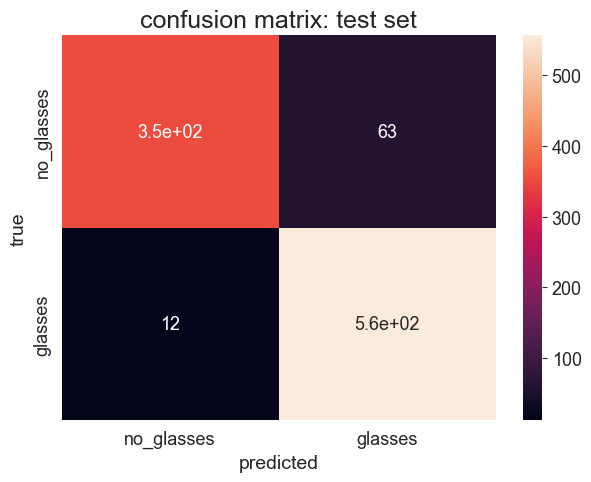

In [12]:
# Clear memory
gc.collect()
torch.cuda.empty_cache()

n_classes =  len(np.unique(y_test))   
lab_classes = ['no_glasses','glasses']

scattering = Scattering2D(J=2, L=8, shape=(128,128)).to(device)
model_test_ScatNet = ScatNet2D(input_channels=81, scattering=scattering).to(device)
best_model_path = r'best\ScatNet_RGB_best_model_trained_100epoch_validation_accuracy_0.8959390862944162_momentum0.0_.pt'
model_test_ScatNet.load_state_dict(torch.load(best_model_path))               
#model_test_ScatNet.load_state_dict(torch.load(r'model\rgb\ScatNet_model_dict_fold_3_trained_100epoch_validation_accuracy_0.9479034307496823_momentum0.0_.pt'))  

test_set = CustomDataset(X_test,y_test)
test_loader = DataLoader(test_set, batch_size=16)

pred_label_test = torch.empty((0,n_classes)).to(device)
true_label_test = torch.empty((0)).to(device)

model_test_ScatNet.eval()
print("test...")
with torch.no_grad():
  for data in test_loader:
    X_te, y_te = data
    b,_,_,_ = X_te.shape
    X_te = X_te.view(b,3,128,128).float().to(device)
    y_te = y_te.to(device)
    output_test = model_test_ScatNet(X_te)
    pred_label_test = torch.cat((pred_label_test,output_test),dim=0)
    true_label_test = torch.cat((true_label_test,y_te),dim=0)

print("f1:",f1_score(true_label_test.cpu(), pred_label_test.cpu().argmax(dim=1).cpu(), average='binary'))
compute_metrics(y_true=true_label_test,y_pred=pred_label_test,lab_classes=lab_classes)    


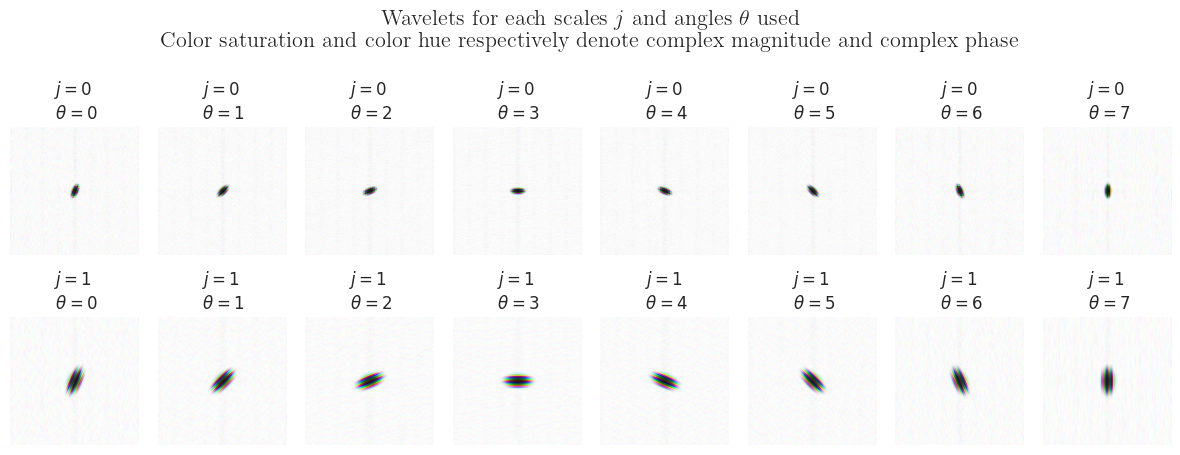

In [13]:
J, L, i = 2, 8, 0

scattering = Scattering2D(J=2, L=8, shape=(128,128)).to(device)

fig, axs = plt.subplots(J, L, sharex=True, sharey=True, )
fig.set_figheight(5)
fig.set_figwidth(12)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Plot the wavelets
for filter in scattering.psi:
    f = filter["levels"][0]
    filter_c = fft2(f)
    filter_c = np.fft.fftshift(filter_c)
    axs[i // L, i % L].imshow(colorize(filter_c))
    axs[i // L, i % L].axis('off')
    axs[i // L, i % L].set_title("$j = {}$ \n $\\theta={}$".format(i // L, i % L), fontsize=12)
    i = i+1

fig.suptitle(r"Wavelets for each scales $j$ and angles $\theta$ used"
             "\nColor saturation and color hue respectively denote complex magnitude and complex phase", fontsize=16)
plt.tight_layout()
plt.show()

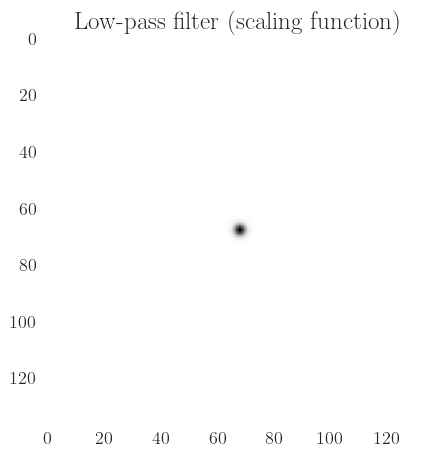

In [14]:
f = scattering.phi["levels"][0]
filter_c = fft2(f)
filter_c = np.fft.fftshift(filter_c)
filter_c = np.abs(filter_c)

plt.figure(figsize=(5,5))
plt.imshow(filter_c, cmap='Greys'); plt.grid(False); plt.title('Low-pass filter (scaling function)')
#plt.imshow(np.log(filter_c), cmap='Greys'); plt.grid(False); plt.title('Low-pass filter (scaling function)')
plt.show()

c:\Users\enric\anaconda3\envs\expCUDA\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


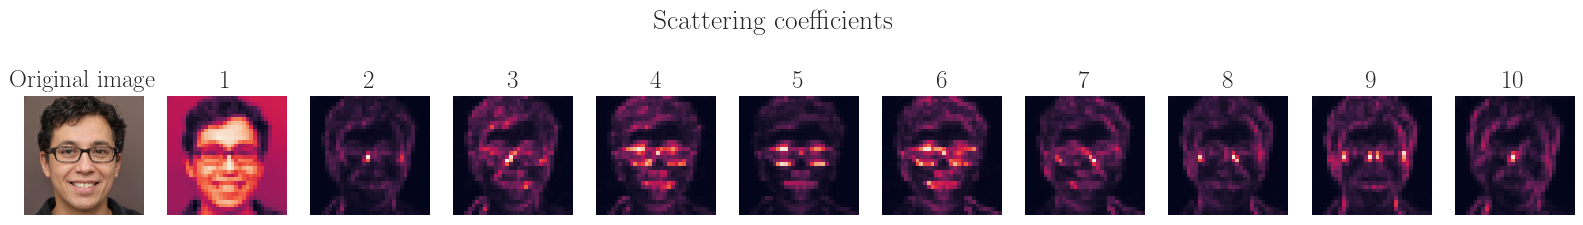

In [15]:
image= Image.open(r'archive_488\Images\Images\glasses\face-3.jpg').convert('RGB')

input_image = preprocess(image).unsqueeze(0).to(device)

scattering = Scattering2D(J=2, L=8, shape=(128,128)).to(device)
scattering_out= scattering(input_image)
scattering_output_np = scattering_out.squeeze(0).cpu().numpy()

aggregated_coefficients = np.mean(scattering_output_np, axis=0)


# Plot the original image and the aggregated scattering coefficients
fig, ax = plt.subplots(1, 11, figsize=(20, 3))
fig.suptitle('Scattering coefficients', fontsize=20)
ax[0].imshow(input_image.squeeze(0).permute(1, 2, 0).cpu())
ax[0].set_title('Original image')
ax[0].axis('off')
for i in range(10):
    ax[i+1].imshow(aggregated_coefficients[i])
    ax[i+1].set_title(str(i+1))
    ax[i+1].axis('off')
plt.show()

